<a href="https://colab.research.google.com/github/VitalyGladyshev/LLM-engineering/blob/main/LLM_GLVV_HW05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Уменьшение размеров модели

Эксперименты будут проводиться с моделью Gemma3 4b

In [ ]:
#pip install -q -U transformers accelerate bitsandbytes

In [ ]:
#pip install -q -U torch

In [ ]:
import pandas as pd
from typing import Literal, Optional, List
import time
import gc

import torch
import torch.nn.functional as F
import torch.profiler as profiler
from torch.profiler import profile, ProfilerActivity, record_function, tensorboard_trace_handler
import tensorboard

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, set_seed

set_seed(42)

In [ ]:
print(f"PyTorch: {torch.__version__} | CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    dev = torch.cuda.get_device_name(0)
    mem_total = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"GPU: {dev}, VRAM: {mem_total:.1f} GB")

PyTorch: 2.6.0+cu126 | CUDA available: True
GPU: NVIDIA GeForce RTX 3090 Ti, VRAM: 24.0 GB


## Базовый проход для полной модели

In [ ]:
class LLM:
    """
    Универсальный класс для загрузки и использования больших языковых моделей (LLM).
    Поддерживает полную и квантованную загрузку через Hugging Face Transformers.
    """

    def __init__(self,
                 model_name: str,
                 load_type: Literal['full', 'quantized'] = 'full',
                 quant_type: Optional[Literal['nf4', 'fp4']] = None):
        """
        Инициализация LLM

        Args:
            model_name (str): Идентификатор модели на Hugging Face Hub.
            load_type (str): 'full' для полной версии, 'quantized' для 4-битной квантованной.
            quant_type (str, optional): 'nf4' или 'fp4'. Требуется при load_type='quantized'.
        """
        self.model_name = model_name
        self.load_type = load_type
        self.quant_type = quant_type
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Валидация аргументов
        if load_type == 'quantized' and quant_type is None:
            raise ValueError("Для квантованной загрузки необходимо указать quant_type ('nf4' или 'fp4')")

        # Конфигурация квантования
        quantization_config = None
        if load_type == 'quantized':
            quantization_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_quant_type=quant_type,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_compute_dtype=torch.bfloat16
            )

        # Загрузка токенизатора
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        # Загрузка модели
        if load_type == 'full':
            self.model = AutoModelForCausalLM.from_pretrained(
                model_name,
                dtype=torch.bfloat16,
                device_map="auto" if self.device == "cuda" else None,
            )
        else:  # quantized
            self.model = AutoModelForCausalLM.from_pretrained(
                model_name,
                quantization_config=quantization_config,
                device_map="auto",
                dtype=torch.bfloat16,
            )

        self.model.eval()  # Переключение в режим inference

    def tokenize(self, prompt: str) -> dict:
        """Токенизация промта с возвращением inputs."""
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)
        return inputs

    def generate_with_inputs(self, inputs: dict, max_tokens: int = 100) -> torch.Tensor:
        """
        Генерация на основе уже токенизированных inputs
        для измерения метрик производительности.
        """
        with torch.no_grad():
            output = self.model.generate(
                **inputs,
                max_new_tokens=max_tokens,
                do_sample=False,
                pad_token_id=self.tokenizer.eos_token_id
            )
        return output

    def generate(self, prompt: str, max_tokens: int = 100) -> str:
        """Генерация ответа на основе промта."""
        inputs = self.tokenize(prompt)
        output = self.generate_with_inputs(inputs, max_tokens)
        response_text = self.tokenizer.decode(output[0], skip_special_tokens=True)
        return response_text

    def profile_generation(self, inputs: dict, max_tokens: int, profiler_dir: str):
        """Выполняет генерацию с профилированием для анализа производительности."""
        with profile(
            activities=[ProfilerActivity.CPU] +
                     ([ProfilerActivity.CUDA] if torch.cuda.is_available() else []),
            record_shapes=True,
            profile_memory=True,
            with_stack=True,
            on_trace_ready=tensorboard_trace_handler(profiler_dir),
        ) as prof:
            # Prefill phase
            with torch.no_grad():
                out = self.model(**inputs, use_cache=True)
                past_key_values = out.past_key_values
                next_token = out.logits[:, -1, :].argmax(dim=-1, keepdim=True)

            # Decode phases
            for _ in range(max_tokens - 1):
                with torch.no_grad():
                    out = self.model(
                        input_ids=next_token,
                        past_key_values=past_key_values,
                        use_cache=True
                    )
                    past_key_values = out.past_key_values
                    next_token = out.logits[:, -1, :].argmax(dim=-1, keepdim=True)

        print(prof.key_averages().table(
            sort_by="self_cuda_time_total" if torch.cuda.is_available() else "self_cpu_time_total",
            row_limit=20
        ))

    def cleanup(self):
        """Освобождение памяти, занятой моделью"""
        if hasattr(self, 'model'):
            del self.model
        if hasattr(self, 'tokenizer'):
            del self.tokenizer

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()

        gc.collect()

In [ ]:
class Experiment:
    """
    Класс экспериментов по измерению метрик производительности LLM.
    """

    def __init__(self):
        """Инициализация эксперимента."""
        self.results_df = pd.DataFrame()

    def measure_generation_metrics(self, model: LLM, prompt: str, max_tokens: int = 100) -> dict:
        """Измерение метрик генерации для данного промта."""
        # Токенизация промта
        inputs = model.tokenize(prompt)
        input_length = inputs['input_ids'].shape[1]

        # Сброс статистики памяти
        torch.cuda.reset_peak_memory_stats()

        # Замер Time to First Token (TTFT)
        start_time = time.time()
        first_token_output = model.generate_with_inputs(inputs, max_tokens=1)
        ttft = time.time() - start_time

        # Замер полной генерации (E2E Latency)
        start_time_full = time.time()
        full_output = model.generate_with_inputs(inputs, max_tokens=max_tokens)
        e2e_latency = time.time() - start_time_full

        # Расчет метрик
        generated_tokens = full_output[0, input_length:].numel()
        generation_time = e2e_latency - ttft
        tps = generated_tokens / generation_time if generation_time > 0 else 0

        # Использование VRAM
        vram_usage = torch.cuda.max_memory_allocated() / (1024 ** 3)  # в ГБ

        # Декодирование ответа
        response_text = model.tokenizer.decode(full_output[0], skip_special_tokens=True)

        return {
            'response_text': response_text,
            'vram_usage': vram_usage,
            'ttft': ttft,
            'tps': tps,
            'e2e_latency': e2e_latency,
            'generated_tokens': generated_tokens
        }

    def run_experiment(self,
                       model: LLM,
                       prompts: List[str],
                       num_runs: int = 5,
                       max_tokens: int = 100) -> pd.DataFrame:
        """
        Проведение серии экспериментов с различными длинами последовательностей.

        Args:
            model: LLM
            prompts (List[str]): Промпты разной длины.
            num_runs (int): Количество запусков для каждого эксперимента (первый отбрасывается).
            max_tokens (int): Максимальное количество токенов для генерации.

        Returns:
            pd.DataFrame: DataFrame с результатами всех экспериментов.
        """
        results = []

        for prompt in prompts:
            len_prompt = len(prompt)
            print(f"Проведение эксперимента с длиной последовательности L={len_prompt}...")

            run_metrics = []

            # Несколько запусков для усреднения (первый отбрасывается)
            for run in range(num_runs + 1):
                metrics = self.measure_generation_metrics(model, prompt, max_tokens)

                if run > 0:  # Первый запуск отбрасывается (прогрев)
                    run_metrics.append(metrics)

                time.sleep(1)

            # Усреднение метрик по запускам
            avg_metrics = {
                'sequence_length': len_prompt,
                'vram_usage_avg': sum(m['vram_usage'] for m in run_metrics) / len(run_metrics),
                'ttft_avg': sum(m['ttft'] for m in run_metrics) / len(run_metrics),
                'tps_avg': sum(m['tps'] for m in run_metrics) / len(run_metrics),
                'e2e_latency_avg': sum(m['e2e_latency'] for m in run_metrics) / len(run_metrics),
                'vram_usage_std': pd.Series([m['vram_usage'] for m in run_metrics]).std(),
                'ttft_std': pd.Series([m['ttft'] for m in run_metrics]).std(),
                'tps_std': pd.Series([m['tps'] for m in run_metrics]).std(),
                'e2e_latency_std': pd.Series([m['e2e_latency'] for m in run_metrics]).std(),
            }

            results.append(avg_metrics)

        # Сохранение результатов в DataFrame
        self.results_df = pd.DataFrame(results)
        return self.results_df

    def save_results_to_csv(self, filename: str):
        """
        Сохранение результатов эксперимента в CSV файл.

        Args:
            filename (str): Имя файла для сохранения.
        """
        if not self.results_df.empty:
            self.results_df.to_csv(filename, index=False, encoding='utf-8')
            print(f"Результаты сохранены в файл: {filename}")
        else:
            print("Нет данных для сохранения.")

In [ ]:
MODEL_NAME = "google/gemma-3-4b-it"
NUM_RUNS = 5
MAX_TOKENS = 100

In [ ]:
prompt_36 = "Что такое обучение с подкреплением?"

prompt_300 = "Объясни концепцию трансформеров в глубоком обучении. " \
"Опиши ключевые компоненты архитектуры: механизм внимания, positional encoding, feed-forward сети. " \
"Кратко объясни, почему трансформеры revolutionized обработку естественного языка и какие " \
"преимущества они offer по сравнению с рекуррентными сетями."

prompt_908 = """Перенос обучения (Transfer Learning) — это метод машинного
обучения, при котором модель, обученная на одной задаче, повторно используется
для решения другой, но связанной задачи. Это особенно полезно в глубоком
обучении, где обучение с нуля требует огромных вычислительных ресурсов и
большого количества размеченных данных. Например, модели, предварительно
обученные на большом наборе данных ImageNet, успешно используются для таких
задач, как классификация изображений, обнаружение объектов и сегментация.
Процесс обычно включает в себя заморозку первых нескольких слоев предобученной
модели и дообучение последних слоев на целевом наборе данных. Объясни, почему
заморозка начальных слоев является важным шагом? Какие существуют стратегии
выбора количества замораживаемых слоев? Также опиши, как перенос обучения
применяется в обработке естественного языка, например, с использованием BERT или GPT моделей."""

In [ ]:
prompt_300

'Объясни концепцию трансформеров в глубоком обучении. Опиши ключевые компоненты архитектуры: механизм внимания, positional encoding, feed-forward сети. Кратко объясни, почему трансформеры revolutionized обработку естественного языка и какие преимущества они offer по сравнению с рекуррентными сетями.'

In [ ]:
prompts = [prompt_36, prompt_300, prompt_908]

In [ ]:
prompts[0]

'Что такое обучение с подкреплением?'

In [ ]:
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

In [ ]:
experiment = Experiment()

print("Эксперименты с полной моделью")
full_model = LLM(MODEL_NAME, load_type='full')

full_results = experiment.run_experiment(
    full_model, prompts, NUM_RUNS, MAX_TOKENS
)
experiment.save_results_to_csv('full_model_results.csv')

print("Освобождение памяти от полной модели...")
full_model.cleanup()
del full_model

Эксперименты с полной моделью


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Проведение эксперимента с длиной последовательности L=35...
Проведение эксперимента с длиной последовательности L=299...
Проведение эксперимента с длиной последовательности L=907...
Результаты сохранены в файл: full_model_results.csv
Освобождение памяти от полной модели...


In [ ]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
gc.collect()

time.sleep(5)

## Базовый проход для квантованной модели

In [ ]:
full_results = pd.read_csv('full_model_results.csv')

experiment = Experiment()

In [ ]:
full_results

,sequence_length,vram_usage_avg,ttft_avg,tps_avg,e2e_latency_avg,vram_usage_std,ttft_std,tps_std,e2e_latency_std
0,35,7.950990,0.369671,6.446610,15.916129,0.0,0.046892,0.343752,0.842685
1,299,7.955415,0.413231,6.543944,15.712025,0.0,0.086460,0.248288,0.541444
2,907,7.968552,0.506723,6.870680,15.085689,0.0,0.085203,0.305845,0.690199


In [ ]:
print("Эксперименты с квантованной моделью")
quantized_model = LLM(MODEL_NAME, load_type='quantized', quant_type='nf4')

quantized_results = experiment.run_experiment(
    quantized_model, prompts, NUM_RUNS, MAX_TOKENS
)
experiment.save_results_to_csv('quantized_model_results.csv')

Эксперименты с квантованной моделью


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Проведение эксперимента с длиной последовательности L=35...
Проведение эксперимента с длиной последовательности L=299...
Проведение эксперимента с длиной последовательности L=907...
Результаты сохранены в файл: quantized_model_results.csv


In [ ]:
print("Освобождение памяти от квантованной модели...")
quantized_model.cleanup()
del quantized_model

Освобождение памяти от квантованной модели...


In [ ]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
gc.collect()

time.sleep(5)

In [ ]:
comparison_df = pd.merge(
    full_results.add_prefix('full_'),
    quantized_results.add_prefix('quant_'),
    left_on='full_sequence_length',
    right_on='quant_sequence_length'
)

In [ ]:
comparison_df.to_csv('model_comparison.csv', index=False, encoding='utf-8')

In [ ]:
comparison_df

,full_sequence_length,full_vram_usage_avg,full_ttft_avg,full_tps_avg,full_e2e_latency_avg,full_vram_usage_std,full_ttft_std,full_tps_std,full_e2e_latency_std,quant_sequence_length,quant_vram_usage_avg,quant_ttft_avg,quant_tps_avg,quant_e2e_latency_avg,quant_vram_usage_std,quant_ttft_std,quant_tps_std,quant_e2e_latency_std
0,35,7.950990,0.369671,6.446610,15.916129,0.0,0.046892,0.343752,0.842685,35,1.611302,0.418367,5.194739,19.686083,0.0,0.119699,0.171843,0.620459
1,299,7.955415,0.413231,6.543944,15.712025,0.0,0.086460,0.248288,0.541444,299,1.611305,0.535040,5.274823,19.661945,0.0,0.171330,0.551501,1.899401
2,907,7.968552,0.506723,6.870680,15.085689,0.0,0.085203,0.305845,0.690199,907,1.611311,0.482678,5.250654,19.662066,0.0,0.099180,0.469597,1.857467


In [ ]:
def plot_comparison(results_df: pd.DataFrame):
    """
    Построение графиков сравнения метрик полной и квантованной моделей.
    """
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Определяем маркеры для разных моделей
    markers = {'Full Model': 'o', 'Quantized Model': 's'}

    # VRAM Usage
    sns.lineplot(data=results_df, x='full_sequence_length', y='full_vram_usage_avg',
                 label='Full Model', ax=axes[0, 0], marker='o', markersize=8)
    sns.lineplot(data=results_df, x='full_sequence_length', y='quant_vram_usage_avg',
                 label='Quantized Model', ax=axes[0, 0], marker='s', markersize=8)
    axes[0, 0].set_title('Использование VRAM')
    axes[0, 0].set_xlabel('Sequence Length')
    axes[0, 0].set_ylabel('VRAM Usage (GB)')
    axes[0, 0].grid(True, linestyle='--', alpha=0.7)

    # TTFT Comparison
    sns.lineplot(data=results_df, x='full_sequence_length', y='full_ttft_avg',
                 label='Full Model', ax=axes[0, 1], marker='o', markersize=8)
    sns.lineplot(data=results_df, x='full_sequence_length', y='quant_ttft_avg',
                 label='Quantized Model', ax=axes[0, 1], marker='s', markersize=8)
    axes[0, 1].set_title('TTFT')
    axes[0, 1].set_xlabel('Sequence Length')
    axes[0, 1].set_ylabel('Time to First Token (s)')
    axes[0, 1].grid(True, linestyle='--', alpha=0.7)

    # TPS Comparison
    sns.lineplot(data=results_df, x='full_sequence_length', y='full_tps_avg',
                 label='Full Model', ax=axes[1, 0], marker='o', markersize=8)
    sns.lineplot(data=results_df, x='full_sequence_length', y='quant_tps_avg',
                 label='Quantized Model', ax=axes[1, 0], marker='s', markersize=8)
    axes[1, 0].set_title('TPS')
    axes[1, 0].set_xlabel('Sequence Length')
    axes[1, 0].set_ylabel('Tokens Per Second')
    axes[1, 0].grid(True, linestyle='--', alpha=0.7)

    # E2E Latency Comparison
    sns.lineplot(data=results_df, x='full_sequence_length', y='full_e2e_latency_avg',
                 label='Full Model', ax=axes[1, 1], marker='o', markersize=8)
    sns.lineplot(data=results_df, x='full_sequence_length', y='quant_e2e_latency_avg',
                 label='Quantized Model', ax=axes[1, 1], marker='s', markersize=8)
    axes[1, 1].set_title('E2E')
    axes[1, 1].set_xlabel('Sequence Length')
    axes[1, 1].set_ylabel('End-to-End Latency (s)')
    axes[1, 1].grid(True, linestyle='--', alpha=0.7)

    # Добавляем легенду на каждый график
    for ax in axes.flat:
        ax.legend()

    plt.tight_layout()
    plt.savefig('model_comparison_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

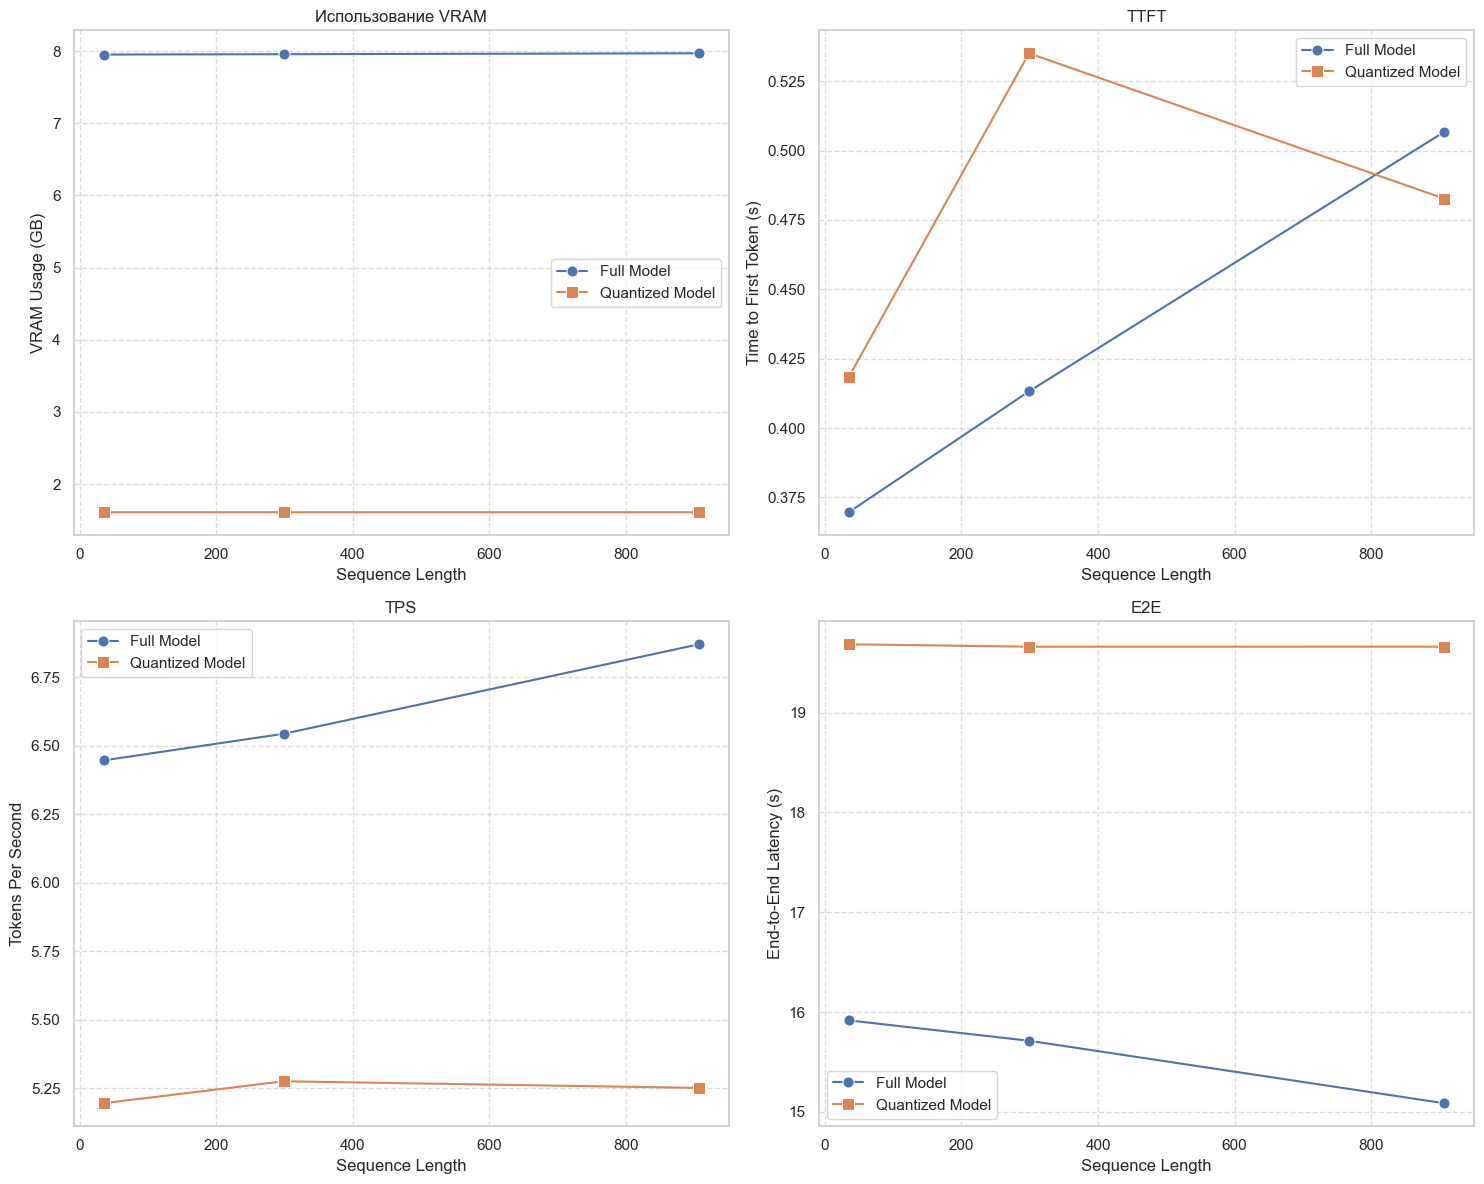

In [ ]:
plot_comparison(comparison_df)

## Профилирование полной модели

In [ ]:
prompt_1000_bool = """Ответь только 'да' или 'нет'. Относится ли данный текст к
тематике машинного обучения:

Перенос обучения (Transfer Learning) — это метод машинного
обучения, при котором модель, обученная на одной задаче, повторно используется
для решения другой, но связанной задачи. Это особенно полезно в глубоком
обучении, где обучение с нуля требует огромных вычислительных ресурсов и
большого количества размеченных данных. Например, модели, предварительно
обученные на большом наборе данных ImageNet, успешно используются для таких
задач, как классификация изображений, обнаружение объектов и сегментация.
Процесс обычно включает в себя заморозку первых нескольких слоев предобученной
модели и дообучение последних слоев на целевом наборе данных. Объясни, почему
заморозка начальных слоев является важным шагом? Какие существуют стратегии
выбора количества замораживаемых слоев? Также опиши, как перенос обучения
применяется в обработке естественного языка, например, с использованием BERT или GPT моделей."""

In [ ]:
full_model = LLM(MODEL_NAME, load_type='full')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Prefill-доминантный сценарий

In [ ]:
inputs_long = full_model.tokenize(prompt_1000_bool)
full_model.profile_generation(
    inputs_long,
    max_tokens=16,
    profiler_dir="./logs/full_prefill_dominant"
)

--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                 aten::copy_         9.12%     139.261ms         9.12%     139.261ms       9.034us     743.123ms        29.35%     743.123ms      48.205us           0 b           0 b           0 b           0 b         15416  
                         a

### Decode-доминантный сценарий

In [ ]:
inputs_short = full_model.tokenize(prompt_300)
full_model.profile_generation(
    inputs_short,
    max_tokens=256,
    profiler_dir="./logs/full_decode_dominant"
)

--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                 aten::copy_         9.73%        2.413s         9.73%        2.413s       9.846us       12.344s        30.88%       12.344s      50.363us           0 b           0 b           0 b           0 b        245096  
                         a

In [ ]:
full_model.cleanup()

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
gc.collect()

time.sleep(5)

In [ ]:
import os
os.getcwd()

'C:\\Users\\AIshared\\LLM'

In [ ]:
%reload_ext tensorboard
%tensorboard  --logdir C:\\Users\\AIshared\\LLM\\logs\\  --port=6005

In [ ]:
!kill 12624
!kill 18436

kill: 12624: No such process
kill: 18436: No such process


In [ ]:
print(f"PyTorch version: {torch.__version__}")
print(f"TensorBoard version: {tensorboard.__version__}")

PyTorch version: 2.6.0+cu126
TensorBoard version: 2.20.0


In [ ]:
trace_file = "C:\\Users\\AIshared\\LLM\\logs\\full_prefill_dominant\\SMIRNOVA2_5584.1758472569490382100.pt.trace.json"
print(f"Файл существует: {os.path.exists(trace_file)}")
print(f"Размер файла: {os.path.getsize(trace_file)} байт")
print(f"Доступен для чтения: {os.access(trace_file, os.R_OK)}")

Файл существует: True
Размер файла: 248102934 байт
Доступен для чтения: True


## Профилирование квантованной модели

In [ ]:
quantized_model = LLM(MODEL_NAME, load_type='quantized', quant_type='nf4')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Prefill-доминантный сценарий

In [ ]:
inputs_long = quantized_model.tokenize(prompt_1000_bool)
quantized_model.profile_generation(
    inputs_long,
    max_tokens=16,
    profiler_dir="./logs/q_prefill_dominant"
)

--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                 aten::copy_         4.87%     182.534ms         4.93%     184.766ms      13.308us        1.103s        19.42%        1.108s      79.837us           0 b           0 b           0 b      -4.00 Kb         13884  
                          

### Decode-доминантный сценарий

In [ ]:
inputs_short = quantized_model.tokenize(prompt_300)
quantized_model.profile_generation(
    inputs_short,
    max_tokens=256,
    profiler_dir="./logs/q_decode_dominant"
)

--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                 aten::copy_         8.63%        2.467s         8.66%        2.475s      11.224us        5.665s        13.99%        5.674s      25.731us           0 b           0 b           0 b      -2.00 Kb        220524  
                         a

In [ ]:
print("Освобождение памяти от квантованной модели...")
quantized_model.cleanup()
del quantized_model

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
gc.collect()

time.sleep(5)

Освобождение памяти от квантованной модели...


In [ ]:
%reload_ext tensorboard
%tensorboard  --logdir ./logs/  --port=6007